# Natural Lanuguage Processing
## Fake news identification

by Daniel Russotto and Christine Utendorf

In this assignment our goal is to determine if a provided article including a title and text provides real or fake news. Fake news consists of disinformation and it imposes a great threat to our today's society. Not knowing what to believe when it comes to news and information or even worse not recognizing that the information provided is not reflecting the truth can truely harm a reader. Especially through the rise of the internet and with it the rise of social media, news can be accessed at any time, any place and from many different sources. However, this also gives fake news the possibility to spread faster, wider and more successfully.

Social media giant Facebook has set up a unit to identify such fake news on its platform. After being critized more than ones for doing to little against the spread of false infromation, Facebook is now "working to stop misinformation and false news". The company is not only working together with third-party fact-check organizations but is also applying machine learning techniques to identify such post that contain fake news (see more under the [link](https://www.facebook.com/facebookmedia/blog/working-to-stop-misinformation-and-false-news)). It is highly likely that Facebook uses Natural Language Processing and classification algorithms in order to determine if they have fraud in front of them or not.

In this assignment we (Dan and Christine) are going to work on such a problem that Facebook (as well as Twitter, Youtube, and many other platforms) is facing everyday: Identifying is an article provides real or fake news. We are not going to use fact-checking in order to prove if an information is acurate, but train a machine learning algorithm to classify articles as fake or real. In order to do so we are using several concepts of natural language processing such as tokenization and lemmatization from the NLTK python library as well as machine learning concepts including logistic regression and naive bayes from the sklearn python library. For this puprpose we were provided with a training data set that includes articels that are already labled as real or fake and a test set without such labels. The goal is to train a model that is able to find a general pattern to identify fake news among articles it has never seen before (here our "blind" test data set).

### Library loading

In [106]:
import pandas as pd 
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')
import sklearn

from nltk.stem import PorterStemmer, WordNetLemmatizer
from functools import reduce
from nltk import word_tokenize, WordPunctTokenizer
from nltk.corpus import wordnet, stopwords
import re

from functools import reduce
from nltk import word_tokenize, WordPunctTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data sets

In [2]:
train_data = pd.read_csv("data/fake_or_real_news_training.csv", quotechar='"', header=0, sep=",",
                    index_col="ID", encoding='utf-8')
test_data = pd.read_csv("data/fake_or_real_news_test.csv", quotechar='"', header=0, sep=",",
                   index_col="ID", encoding='utf-8')

#### Train data set
The training data set has 3,999 rows each representing an article. All articles are identified with a unique id, have a title, text and a label if they are fake or real. Furthermore there are the columns X1 and X2. These two columns should actually be all filled with NaN (=empty). However, 33 rows show values in X1 and 2 of these 33 also in X2. This shows that the text was not properly splitted in these cases. The separator used to splitt the csv into a dataframe is "," but as it seems in some of the cases this did not split all rows correctly. In the data cleaning part we will take a closer look at this.

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 8476 to 9673
Data columns (total 5 columns):
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: object(5)
memory usage: 187.5+ KB


In [4]:
train_data.head(5)

,title,text,label,X1,X2
ID,,,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


#### Test data
The test data set consists of 2321 unlabeled rows and due to the fact that the data frame only includes the unique id, the title and the actual text it seems as the text split worked well here (no X1 or X2). The train data has less than double the amount of articles in it compared to the test data set. This makes it crucial to retrain at the end the machine learning with the complete train data set due to limited data availability.

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 10498 to 4330
Data columns (total 2 columns):
title    2321 non-null object
text     2321 non-null object
dtypes: object(2)
memory usage: 54.4+ KB


In [6]:
test_data.head(5)

,title,text
ID,,
10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


### 1.2 Data cleaning
As seen in the train_data.info() we have several rows that were not correctly put in the dataframe. We are now going to fix these rows. The csv is splitted using commas. Thus a title or text that has commas in it is splitted incorrectly. A first step is to filter out the rows that are displaced and take a closer look at them. Overall, we have 33 rows with displaced values since all the rows that have values in X2 have values in X1. It is important to fix these values due to the limited number of training rows.

In [7]:
displaced_rows = train_data[train_data.X1.notnull()]
displaced_rows

,title,text,label,X1,X2
ID,,,,,
599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN
7375,Shallow 5.4 magnitude earthquake rattles centr...,shakes buildings in Rome,00 UTC © USGS Map of the earthquake's epicent...,FAKE,NaN
9097,ICE Agent Commits Suicide in NYC,Leaves Note Revealing Gov’t Plans to Round-up...,Email Print After writing a lengthy suicide no...,FAKE,NaN
9203,Political Correctness for Yuengling Brewery,What About Our Opioid Epidemic?,We Are Change \r\n\r\nIn today’s political cli...,FAKE,NaN
1602,Poll gives Biden edge over Clinton against GOP...,VP meets with Trumka,A new national poll shows Vice President Biden...,REAL,NaN


Overall, it seems that the problem lies within the title. For the 31 cases that have only one misplacement (X2 = NaN), the title was splitted into two causing that the actual label is within the X1 column and the article text in the label column. For the double splitted row with index 9, it actually seems that in the title were two commas leading to a double split. However the row with index 6268 repeats the wrongly splitted phrase just again in the label and X1. There is no sign of further text and thus this row should be excluded since it does not provide an actual article text.
However, lets start with the rows that have one wrong column break by joining the title and the text field back together into the full title and then replace the text and label column with the actual values.

In [8]:
train_data.loc[train_data.X1.notnull(), 'title'] = train_data.loc[train_data.X1.notnull(), 'title'] + train_data.loc[train_data.X1.notnull(), 'text']
train_data.loc[train_data.X1.notnull(), 'text'] = train_data.loc[train_data.X1.notnull(), 'label']
train_data.loc[train_data.X1.notnull(), 'label'] = train_data.loc[train_data.X1.notnull(), 'X1']
train_data.loc[train_data.X1.notnull(), 'X1'] = train_data.loc[train_data.X1.notnull(), 'X2']

After fixing the line break for the first 31 rows, we are now gonna look at the last two displaced rows. While the row with index 9 seems to be easy to fix, the row with id 6268 does not seem to actually have text but only a title. Thus first we are going to fix row 9 and then see if we have more cases in the data set where there is only a title but no text in order to decide how to deal with row 6268.

In [9]:
displaced_rows = train_data[train_data.X1.notnull()]
displaced_rows

,title,text,label,X1,X2
ID,,,,,
9,Planned Parenthood’s lobbying effort pay raise...,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL,REAL
6268,Chart Of The Day: Since 2009—–Recovery For The...,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,FAKE,FAKE


#### Fix row 9

In [10]:
train_data.loc[9, 'title'] = train_data.loc[9, 'title'] + "," + train_data.loc[9, 'text']
train_data.loc[9, 'text'] = train_data.loc[9, 'label']
train_data.loc[9, 'label'] = train_data.loc[9, 'X1']
train_data.loc[9, 'X1'] = np.nan
train_data.loc[9, 'X2'] = np.nan

#### Rows with no text
Overall we see that we have 21 rows that only have white space within their text column. Furthermore, we see that all these entries are fake, which is also the case for our displaced row 6268. Thus in order to identify these cases more easily we will insert "zzzzz" in the text column.

In [11]:
empty_text = train_data[train_data.text == ' ']
empty_text

,title,text,label,X1,X2
ID,,,,,
5530,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE,NaN,NaN
8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE,NaN,NaN
9314,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE,NaN,NaN
10304,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE,NaN,NaN
9474,Michael Bloomberg Names Technological Unemploy...,,FAKE,NaN,NaN
5802,Alert News : Putins Army Is Coming For World W...,,FAKE,NaN,NaN
9564,An LDS Reader Takes A Look At Trump Accuser Je...,,FAKE,NaN,NaN
5752,America’s Senator Jeff Sessions Warns of Worse...,,FAKE,NaN,NaN
8816,Paris Migrant Campers Increase after Calais Is...,,FAKE,NaN,NaN


#### Replace empty text with zzzzz

In [12]:
# Replace text for specific row
train_data.loc[6268, 'text'] = "zzzzz"
train_data.loc[6268, 'label'] = train_data.loc[6268, 'X1']


# Fill empty text columns
train_data["text"] = train_data.apply(lambda row: row["text"].strip(), axis=1).replace("", "zzzzz")

# Show zzzzz rows
train_data[train_data["text"] == "zzzzz"]

,title,text,label,X1,X2
ID,,,,,
5530,The Arcturian Group by Marilyn Raffaele Octobe...,zzzzz,FAKE,NaN,NaN
8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,zzzzz,FAKE,NaN,NaN
9314,Southern Poverty Law Center Targets Anti-Jihad...,zzzzz,FAKE,NaN,NaN
10304,Refugee Resettlement Watch: Swept Away In Nort...,zzzzz,FAKE,NaN,NaN
9474,Michael Bloomberg Names Technological Unemploy...,zzzzz,FAKE,NaN,NaN
5802,Alert News : Putins Army Is Coming For World W...,zzzzz,FAKE,NaN,NaN
9564,An LDS Reader Takes A Look At Trump Accuser Je...,zzzzz,FAKE,NaN,NaN
5752,America’s Senator Jeff Sessions Warns of Worse...,zzzzz,FAKE,NaN,NaN
8816,Paris Migrant Campers Increase after Calais Is...,zzzzz,FAKE,NaN,NaN


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 8476 to 9673
Data columns (total 5 columns):
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       1 non-null object
X2       1 non-null object
dtypes: object(5)
memory usage: 347.5+ KB


After fixing the displaced rows we can now delete the columns X1 and X2.

In [14]:
train_data = train_data[['title', 'text','label']]
train_data.head()

,title,text,label
ID,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


#### Test data set
Eventhough the test data set does not show a splitting problem there might be rows that do not have anything in their text column. Thus we are going to check this and then fill the empty columns like we did for the train data set. Apparently there are 15 rows in which the text column is empty.

In [15]:
empty_text_test = test_data[test_data.text == ' ']
empty_text_test

,title,text
ID,,
10414,More on Trump’s Populism and How It Can Be Con...,
6311,Radio Derb transcript for October 29th is up: ...,
8601,Pro-sovereignty Legislators Demand That Admini...,
8626,World War 3?,
8548,A Mormon Reader Says Most Mormons Will Still B...,
6254,Paris: Riot Police Flatten Invader Camp,
8875,Huma Abedin’s Muslim Dad,
9526,Hillary is Sick & Tired of Suffering from Wein...,
6800,Automation: Robots from Korea to America Are R...,


In [16]:
test_data["text"] = test_data.apply(lambda row: row["text"].strip(), axis=1).replace("", "zzzzz")

### 1.2 Data exploration

#### Target distribution
Since we are working on a classification problem, it is important to look at the target distribution. Highly imbalanced targets need resampling methods in order to train a well-working machine learning model. Thus our first step in terms of data exploration is to check the amount of fake and real labels within our data set:

In [17]:
train_data[train_data.label == "REAL"].count()

title    2008
text     2008
label    2008
dtype: int64

In [18]:
train_data[train_data.label == "FAKE"].count()

title    1991
text     1991
label    1991
dtype: int64

The target is almost equally distributed with 2008 real and 1990 fake articles.

#### Real news vs. fake news

<font color=red>
   
- Common words text
- Common words title

- Common words text (w/o stopwords, lowercase)
- Common words title (w/o stopwords, lowercase)

- Distribution of word classes overall (Adj, noun, ...)

- length of title
- length of text

- lexical diversity

</font>

## 2. Text preparation

In order to work with the title and text, the columns need to be cleaned. We follow several steps in order to prepare our data.

### 2.1 POS tagging
The first step before we go into normalizing our texts, is part-of-speech (POS) tagging. POS tagging determines which role a word plays within a sentence. The four most common tags are noun, verb, adjective and adverb. 

We are using POS tagging in order to tag all the words within our title and text to use this as input for the following lemmatization. An easy approach is to apply lemmatization tagging all words either as a verb or a noun. However, this will not always result in a very desirable lemmatization output. Thus we created two function that use the nltk pos_tag function to pos tag the words (postag_text) and then based on these tags we assigned these tags to the four main tag categories (get_wordnet_pos) which are then used beside the word itself as input for our lemmatization process. 

Within the postag_text function it can be determined to remove stopwords, lowercase the words and remove punctuation.

In [19]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #by default is noun

In [20]:
def postag_text(txt, rm_stopwords=True, lowertext=True, rm_punct=True):
    if rm_punct:
        txt = re.sub("[^a-zA-Z]", " ", txt)
        
    tokenized = word_tokenize(txt)
    if lowertext:
        tokenized = list(map(lambda word: word.lower(), tokenized))
        
    if rm_stopwords:
        sw = set(stopwords.words('english'))
        tokenized = list(filter(lambda word: word not in sw, tokenized))
        
    tags = nltk.pos_tag(tokenized)
    return list(map(lambda tag_info: (tag_info[0], get_wordnet_pos(tag_info[1])), tags))

### 2.2 Lemmatizing

Lemmatizing is trying to find the root of a word and replaces this word with its root. For verbs this is the infinitive thus are/is/was etc. is turned to "be". Four nouns the root is usually the singular form. However, there are also other noun transformation such as working, which has the root work. Lemmatizing transforms mainly nouns and in particular verbs, however also adjective can be affected for example by using comparatives and superlatives.

We used the nltk WordNetLemmatizer for lemmatizing our texts. The function we created first tags all the words, which are already lowercased. We decided not to exclude stopwords in this particular step since we are going to use the clean text also to create n-grams in which we think stopwords can actually be helpful. For the same reason punctuation is not removed at this point since for n-grams this is needed due to the fact that n-grams should not go over the end of a sentence. However when we use usual unigrams for vectorization stopwords and punctuation (actually everthing that is not a letter) will be removed. Luckily the WordNetLemmatizer is actually able to lemmatize a word at the end of a sentence eventhough it is connected to a period, question mark etc. (see below).

The next step in this function is to actually lemmatize the words and here as said before we did not include a default tag but used the actually assigned tag from our POS tagging process. At the end the function returns the lemmatized text.

In [21]:
def lemmatize_text(text, lowertext=True, rm_punct=False):
    wnlt = WordNetLemmatizer()
    
    tagged = postag_text(text, rm_stopwords=False, rm_punct=rm_punct)
    
    lemmatized_list = list(map(lambda tag: wnlt.lemmatize(tag[0], pos=tag[1]), tagged))
    
    lemmatized_text = reduce(lambda x, y: x + " " + y, lemmatized_list)
    
    return lemmatized_text

##### Example of lemmatizing

In [22]:
print(lemmatize_text("Dogs run, he ran, she is drinking, people are sitting"))
print(lemmatize_text("Dogs run, he ran, she is drinking, people are sitting?"))

dog run , he run , she be drink , people be sit
dog run , he run , she be drink , people be sit ?


### 2.3 Stemming
The next step after lemmatizing is stemming. Stemming is a much more "brutal" transformation than lemmatizing since stemming actually cuts off words. Most of the time from what we see stemming is applied after lemmatization if the POS tag 'verb' was used for all words in the text. For example, if lemmatization is applied and the default is verb all plural nouns are not transformed to their singular root. However, if stemming is afterwards applied the stemmer will take care of this problem. Since we use individual POS tags for each word we are not facing this problem. However, in order to reduce the overall lexical diversity of our text and to be able to identify words with the actual same meaning we also apply stemming in this case.

<font color=red>
Why are we using word_tokenize here and not our pos tags? I get that this is on the lemmatized stuff, but why here word_tokenizer?
</font>

In [23]:
def stem_text(text, lowertext=True, rm_punct=False):
    pst = PorterStemmer()
    
    if rm_punct:
        text = re.sub("[^a-zA-Z]", " ", text)
    
    tokenized = word_tokenize(text)
    
    if lowertext:
        tokenized = list(map(lambda word: word.lower(), tokenized))
    
    stemmed = reduce(lambda x, y: x + " " + y, list(map(lambda word: pst.stem(word), tokenized)))
    
    return stemmed

### 2.4 Create cleaned columns
Now we are going to apply first lemmatizing (incl. POS tagging) and then stemming to our title and text columns. In order to do so we created a new function that combines those two steps. As seen in the example, while stemming only cuts of the word endings, including lemmatizing actually helps to find the root of words such as be or child.

For our dataframe we are now creating not only the cleaned title and text column by using lemmatizing and stemming but also combine the two cleaned columns into a third column that merges title and text.

Within the clean columns we still have stop words and punctuation but all the words are already lowercased. Title and text are also separated by a period. As said before we are doing this for the later creation of n-grams and due to the fact that the vectorizers actually are able to remove stop words and punctuation.

In [24]:
def stem_lemmatize_text(text, lowertext=True, rm_punct=False):
    lemmatized = lemmatize_text(text, lowertext=lowertext, rm_punct=rm_punct)
    return stem_text(lemmatized, lowertext=lowertext, rm_punct=rm_punct)

In [25]:
def clean_col(df, col):
    return df.apply(lambda row: stem_lemmatize_text(row[col]), axis=1).to_frame(name="clean_{}".format(col))

##### Example

In [26]:
print(stem_text("Dogs run, he ran, she is drinking, people are sitting, children were gaming"))
print(lemmatize_text("Dogs run, he ran, she is drinking, people are sitting, children were gaming"))
print(stem_lemmatize_text("Dogs run, he ran, she is drinking, people are sitting, children were gaming"))

dog run , he ran , she is drink , peopl are sit , children were game
dog run , he run , she be drink , people be sit , child be game
dog run , he run , she be drink , peopl be sit , child be game


#### Train data set

In [27]:
try:
    train_data_clean = pd.read_csv("data/train_data_clean.csv")
except:
    print("File not found. Generating clean text...")
    clean_text = clean_col(train_data, "text")
    clean_title = clean_col(train_data, "title")
    clean_combined = clean_title["clean_title"] + ". " + clean_text["clean_text"]
    clean_combined = clean_combined.rename("clean_combined")

    train_data_clean = pd.concat([train_data,
                            clean_title,
                            clean_text,
                            clean_combined
                           ], axis=1)

    train_data_clean.to_csv("data/train_data_clean.csv")

train_data_clean.head()

,ID,title,text,label,clean_title,clean_text,clean_combined
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillari ’ s fear,"daniel greenfield , a shillman journal fellow ...",you can smell hillari ’ s fear. daniel greenfi...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan commit polit ...,googl pinterest digg linkedin reddit stumbleup...,watch the exact moment paul ryan commit polit ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerri to go to pari in gestur of sympathi,u.s. secretari of state john f. kerri say mond...,kerri to go to pari in gestur of sympathi. u.s...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,berni support on twitter erupt in anger agains...,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",berni support on twitter erupt in anger agains...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,the battl of new york : whi thi primari matter,it 's primari day in new york and front-runn h...,the battl of new york : whi thi primari matter...


#### Test data set

In [28]:
try:
    test_data_clean = pd.read_csv("data/test_data_clean.csv")
except:
    print("File not found. Generating clean text...")
    clean_text = clean_col(test_data, "text")
    clean_title = clean_col(test_data, "title")
    clean_combined = clean_title["clean_title"] + ". " + clean_text["clean_text"]
    clean_combined = clean_combined.rename("clean_combined")

    test_data_clean = pd.concat([test_data,
                            clean_title,
                            clean_text,
                            clean_combined
                           ], axis=1)

    test_data_clean.to_csv("data/test_data_clean.csv")

test_data_clean.head()

,ID,title,text,clean_title,clean_text,clean_combined
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,septemb new home sale rise——-back to 1992 level !,septemb new home sale rise back to 1992 level ...,septemb new home sale rise——-back to 1992 leve...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,whi the obamacar doomsday cult ca n't admit it...,but when congress debat and pass the patient p...,whi the obamacar doomsday cult ca n't admit it...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"sander , cruz resist pressur after ny loss , v...",the berni sander and ted cruz campaign vow to ...,"sander , cruz resist pressur after ny loss , v..."
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,surviv escap prison like fatigu and prone to m...,polic search for the second of two escap priso...,surviv escap prison like fatigu and prone to m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,clinton and sander neck and neck in california...,no matter who win california 's 475 deleg on t...,clinton and sander neck and neck in california...


## 3. Feature engineering

After cleaning the data set we are going to create several features based on our columns. We are not going to include all features right aways or all at the same time but since we are already working with the data it makes sense to start creating features that will later be included and tried within the models.

### 3.1 POS-tag distribution

The first feature that we created is related to the POS tags within the title and the text. As seen before in our data preparation part we created a function to tag the title and the text using four different tags. For each title as well as each text we are now using these tags and calculate the actual distribution of nouns, verbs, adjectives and adverbs within each title and each text. These number range from 0 to 1 reflecting the percentage of the title or text that are reflected by one of the four tags. We are not going create these features for the combined column consisting of title and text since most of the time the distribution will be close to the one from the text column. Overall we end up with eight new columns (=features), four of them for title and four of them for text. These four columns types represent the respecitve percentage of one of the four tags within the title or text.

In order to create this distribution the text was not only lowercased but also only letter were included as well as stop words were removed. We took these steps in order to only include words that hold actual informative value and calculate the distribution based on this.

In [29]:
def tag_counts(pos_tags):
    counts = {}
    for word, tag in pos_tags:
        if tag in counts:
            counts[tag] += 1
        else:
            counts[tag] = 1
    return counts

def tag_dists(counts):
    total_words = sum(counts.values())
    dists = {}
    for tag, count in counts.items():
        dists[tag] = count / total_words
    return dists

def create_dists_series(text):
    return tag_dists(tag_counts(postag_text(text)))

def create_dists_df(df, col):
    return pd.DataFrame(list(df.apply(lambda row: create_dists_series(row[col]), axis=1)))
    #     as_series = df.apply(lambda row: create_dists_row(row["text"]), axis=1)

    #     pd.Dataframe({"n": as_series["n"]})

In [30]:
def create_title_dists(df):
    df = create_dists_df(df, "title")

    df = df.rename(columns={'a': 'title_adj_dist',
                            'n': 'title_noun_dist',
                            'v': 'title_verb_dist',
                            'r': 'title_adverb_dist'})
    # Titles are short, certain word types may not appear
    df = df.fillna(0)
    
    return df


def create_text_dists(df):
    df = create_dists_df(df, "text")

    df = df.rename(columns={'a': 'text_adj_dist',
                            'n': 'text_noun_dist',
                            'v': 'text_verb_dist',
                            'r': 'text_adverb_dist'})
    # There are some articles with basically no content (e.g. just a date for a picture)
    df = df.fillna(0)
    
    return df

#### Train data set

In [31]:
train_data_clean_dist = pd.concat([train_data_clean.reset_index(),
                                   create_title_dists(train_data_clean), 
                                   create_text_dists(train_data_clean)], 
                                  axis=1)
train_data_clean_dist.head()

,index,ID,title,text,label,clean_title,clean_text,clean_combined,title_adj_dist,title_noun_dist,title_adverb_dist,title_verb_dist,text_adj_dist,text_noun_dist,text_adverb_dist,text_verb_dist
0,0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillari ’ s fear,"daniel greenfield , a shillman journal fellow ...",you can smell hillari ’ s fear. daniel greenfi...,0.333333,0.666667,0.0,0.000000,0.210448,0.505970,0.073134,0.210448
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan commit polit ...,googl pinterest digg linkedin reddit stumbleup...,watch the exact moment paul ryan commit polit ...,0.181818,0.727273,0.0,0.090909,0.150000,0.545833,0.083333,0.220833
2,2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerri to go to pari in gestur of sympathi,u.s. secretari of state john f. kerri say mond...,kerri to go to pari in gestur of sympathi. u.s...,0.200000,0.600000,0.0,0.200000,0.253112,0.514523,0.024896,0.207469
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,berni support on twitter erupt in anger agains...,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",berni support on twitter erupt in anger agains...,0.125000,0.625000,0.0,0.250000,0.226337,0.497942,0.041152,0.234568
4,4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,the battl of new york : whi thi primari matter,it 's primari day in new york and front-runn h...,the battl of new york : whi thi primari matter...,0.400000,0.600000,0.0,0.000000,0.196629,0.528090,0.028090,0.247191


#### Test data set

In [32]:
test_data_clean_dist = pd.concat([test_data_clean.reset_index(),
                                   create_title_dists(test_data_clean), 
                                   create_text_dists(test_data_clean)], 
                                  axis=1)
test_data_clean_dist.head()

,index,ID,title,text,clean_title,clean_text,clean_combined,title_adj_dist,title_noun_dist,title_adverb_dist,title_verb_dist,text_adj_dist,text_noun_dist,text_adverb_dist,text_verb_dist
0,0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,septemb new home sale rise——-back to 1992 level !,septemb new home sale rise back to 1992 level ...,septemb new home sale rise——-back to 1992 leve...,0.142857,0.428571,0.142857,0.285714,0.214286,0.517857,0.071429,0.196429
1,1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,whi the obamacar doomsday cult ca n't admit it...,but when congress debat and pass the patient p...,whi the obamacar doomsday cult ca n't admit it...,0.200000,0.800000,0.000000,0.000000,0.189369,0.508306,0.076412,0.225914
2,2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"sander , cruz resist pressur after ny loss , v...",the berni sander and ted cruz campaign vow to ...,"sander , cruz resist pressur after ny loss , v...",0.222222,0.555556,0.000000,0.222222,0.155452,0.542923,0.055684,0.245940
3,3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,surviv escap prison like fatigu and prone to m...,polic search for the second of two escap priso...,surviv escap prison like fatigu and prone to m...,0.222222,0.333333,0.000000,0.444444,0.143087,0.540193,0.059486,0.257235
4,4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,clinton and sander neck and neck in california...,no matter who win california 's 475 deleg on t...,clinton and sander neck and neck in california...,0.166667,0.333333,0.166667,0.333333,0.187898,0.506369,0.066879,0.238854


### 3.2 Lexical diversity

The next feature is the lexical diversity, which reflects the ratio of different unique words/words stems to the total number of words within a text. The score is between 0 and 1 and the higher the lexcial diversity the more unique different words are included within a text. Lexical diversity belongs to the concept of lexical richness, for example while 'animal', 'beast', 'creature' can all discribe the same concept, these words are not used in the same way or concept. 


<font color=red>

One of our thoughts is that real news should be more linked to fact based reporting while fake news rather use catchy phrases, the lexical diversity score for real news might tend to be higher compared to fake news. Even some rethorical techniques make use of repeating a word several time throughout a speech. Our suspision would be that those techniques are more used in fake than in real news articles. 


WE NEED TO PLOT THIS!
</font>

In order to create the lexical diversity score we used the clean_combined column that stores lemmatized and stemmed text and title. Furthermore, we only used letters (removing special characters and numbers) and excluded stop words.

In [33]:
def lexical_diversity(text):
    # remove everything except letter (including numbers)
    text = re.sub("[^a-zA-Z]", " ", text)
    
    tokenized = word_tokenize(text)
    sw = set(stopwords.words('english'))
    tokenized = list(filter(lambda word: word not in sw, tokenized))
    
    try:
        ld = len(set(tokenized)) / len(tokenized)
    except ZeroDivisionError as e: # Can happen if the entire body is numbers/date
        ld = 1.0
    
    return ld

In [34]:
def lex_div_col(df):
    return df.apply(lambda row: lexical_diversity(row["clean_combined"]), axis=1).rename("lexical_diversity")

#### Train data set

In [35]:
train_all_features = pd.concat([train_data_clean_dist, lex_div_col(train_data_clean_dist)], axis=1)
train_all_features.to_csv("data/train_all_features.csv")
train_all_features.head()

,index,ID,title,text,label,clean_title,clean_text,clean_combined,title_adj_dist,title_noun_dist,title_adverb_dist,title_verb_dist,text_adj_dist,text_noun_dist,text_adverb_dist,text_verb_dist,lexical_diversity
0,0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,you can smell hillari ’ s fear,"daniel greenfield , a shillman journal fellow ...",you can smell hillari ’ s fear. daniel greenfi...,0.333333,0.666667,0.0,0.000000,0.210448,0.505970,0.073134,0.210448,0.592754
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,watch the exact moment paul ryan commit polit ...,googl pinterest digg linkedin reddit stumbleup...,watch the exact moment paul ryan commit polit ...,0.181818,0.727273,0.0,0.090909,0.150000,0.545833,0.083333,0.220833,0.763158
2,2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,kerri to go to pari in gestur of sympathi,u.s. secretari of state john f. kerri say mond...,kerri to go to pari in gestur of sympathi. u.s...,0.200000,0.600000,0.0,0.200000,0.253112,0.514523,0.024896,0.207469,0.678431
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,berni support on twitter erupt in anger agains...,"— kayde king ( @ kaydeek ) novemb 9 , 2016 the...",berni support on twitter erupt in anger agains...,0.125000,0.625000,0.0,0.250000,0.226337,0.497942,0.041152,0.234568,0.699620
4,4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,the battl of new york : whi thi primari matter,it 's primari day in new york and front-runn h...,the battl of new york : whi thi primari matter...,0.400000,0.600000,0.0,0.000000,0.196629,0.528090,0.028090,0.247191,0.625000


#### Test data set

In [36]:
test_all_features = pd.concat([test_data_clean_dist, lex_div_col(test_data_clean_dist)], axis=1)
test_all_features.to_csv("data/test_all_features.csv")
test_all_features.head()

,index,ID,title,text,clean_title,clean_text,clean_combined,title_adj_dist,title_noun_dist,title_adverb_dist,title_verb_dist,text_adj_dist,text_noun_dist,text_adverb_dist,text_verb_dist,lexical_diversity
0,0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,septemb new home sale rise——-back to 1992 level !,septemb new home sale rise back to 1992 level ...,septemb new home sale rise——-back to 1992 leve...,0.142857,0.428571,0.142857,0.285714,0.214286,0.517857,0.071429,0.196429,0.784615
1,1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,whi the obamacar doomsday cult ca n't admit it...,but when congress debat and pass the patient p...,whi the obamacar doomsday cult ca n't admit it...,0.200000,0.800000,0.000000,0.000000,0.189369,0.508306,0.076412,0.225914,0.701258
2,2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"sander , cruz resist pressur after ny loss , v...",the berni sander and ted cruz campaign vow to ...,"sander , cruz resist pressur after ny loss , v...",0.222222,0.555556,0.000000,0.222222,0.155452,0.542923,0.055684,0.245940,0.582781
3,3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,surviv escap prison like fatigu and prone to m...,polic search for the second of two escap priso...,surviv escap prison like fatigu and prone to m...,0.222222,0.333333,0.000000,0.444444,0.143087,0.540193,0.059486,0.257235,0.570552
4,4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,clinton and sander neck and neck in california...,no matter who win california 's 475 deleg on t...,clinton and sander neck and neck in california...,0.166667,0.333333,0.166667,0.333333,0.187898,0.506369,0.066879,0.238854,0.563636


## 4. Vectorization

After preparing our train and test data sets we are going to create the function that later vectorize our texts. For machine learning models in NLP we actually transform our texts into vectors. These vectors show how often a word / n-gram (=column) appears in a text (=row). To create our vectors we use the CountVectorizer that already removes punctuation and has an option to remove stopwords. When we are creating unigrams we are removing stop words, while for ngrams we are keeping stopwords. The CountVectorizer is also used to create vectors for bigrams and trigrams. This can be done just by defining the ngram range within CountVectorizer: bigram = ngram_range=[2,2], trigram = ngram_range=[3,3].

At the beginning of our modelling we will start with unigrams and later in the modelling part compare it to the results of using bi-grams and tri-grams.

For these different types of vectors we created functions that take in a specific column of a data frame that is supposed to be vectorized. As default we set our clean_combined column, however these functions can also be applied to other columns such as the clean_title or clean_text.

In [2]:
# def unigram_counts(df, col="clean_combined"):
#     vec = CountVectorizer(stop_words=stopwords.words("english"))
#     X = vec.fit_transform(list(df[col]))
    
#     return pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).drop("label", axis=1) # hack

In [3]:
# def bigram_counts(df, col="clean_combined"):
#     vec = CountVectorizer(ngram_range=[2,2])
#     X = vec.fit_transform(list(df[col]))
    
#     return pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# def trigram_counts(df, col="clean_combined"):
#     vec = CountVectorizer(ngram_range=[3,3])
#     X = vec.fit_transform(list(df[col]))
    
#     return pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

<font color=red>
DESCRIBE TF_IDF

</font>

In [4]:
# def tf_idf(df, col="clean_combined"):
#     vec = TfidfVectorizer(stop_words=stopwords.words("english"))
#     X = vec.fit_transform(list(df[col]))
    
#     return pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).drop("label", axis=1) # hack

## 5. Classification modelling
In order to evaluate the performance of our models we will use 5-folds cross-validation.

<font color=red>

- Naive Bayes
- Max Entropy Classifier (Logistic Regression)
- SVM Classifier

Furhter steps
- Include bi-grams, tri-grams
- Include TF-IDF

</font>

In [37]:
# We've had a bit of issues with memory errors, so clean our workspace of everything we don't need at the moment

del train_data
del train_data_clean
del test_data
del test_data_clean
del test_all_features

In [38]:
def grid_search_model(data, model_meta, folds=5, drop=[]):
    """
    Perform Grid Search Cross Validation on the input model

    :param data: a pandas dataframe where each row is an hour
    :param model_meta: An dict containing the name for the model ("name"), the sklearn estimator ("model"),
                    and the parameters for Grid Search Cross Validation ("params")
    :param folds: The number of splits for cross validation
    :return: a tuple containing the best accuracy score found, the parameters used to obtain that score,
                and the estimator retrained on the whole dataset
    """
    model = model_meta["model"]
    model_params = model_meta["params"]
    model_name = model_meta["name"]

    to_drop = drop+["label", "index", "ID", "text", "title", "clean_text", "clean_title", "clean_combined"]
    X = data.drop(columns=to_drop)
    y = data["label"]

    kfold = KFold(n_splits=folds)

    grid_search = GridSearchCV(estimator=model, param_grid=model_params, scoring="accuracy", cv=kfold, refit=True)
    
    #print("Shape: {}".format(y.iloc[0:1,]))
    #print(X.head())
    
    grid_search.fit(X, y)

    print("\tAverage result for best {}: {} +/- {:.5f}"
          .format(model_name,
                  grid_search.best_score_,
                  grid_search.cv_results_["std_test_score"][np.argmax(grid_search.cv_results_["mean_test_score"])]))

    print("\tBest parameters for {0}: {1}".format(model_name, grid_search.best_params_))

    # Need metrics to choose model, best estimator will have already been retrained on whole data set
    
    retval = ({
        "model_name": [model_name],
        "best_acc": [grid_search.best_score_],
        "best_params": [str(grid_search.best_params_)]
    }, grid_search.best_estimator_)
    
    return retval    
    
    #return model_name, grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [39]:
def save_result(result):
    meta_info = result[0]
    model = result[1]
    
    new_row = pd.DataFrame(meta_info)
    model_results = pd.read_csv("models/model_results.csv")
    new_results = pd.concat([model_results, new_row], ignore_index=True)  #model_result.append(new_row)
    new_results.to_csv("models/model_results.csv", index=False)
    
    dump(model, "models/{}.joblib".format(meta_info["model_name"][0]))
         
    return new_results
    

Logit our features

In [40]:
logit_no_vectorization = {
    "model": LogisticRegression(),
    "name": "logit_no_vectorization",
    "params": {
        "penalty": ["l1", "l2"]
    }
}

save_result(grid_search_model(train_all_features, logit_no_vectorization))

pd.read_csv("models/model_results.csv")

	Average result for best logit_no_vectorization: 0.5743935983995999 +/- 0.00883
	Best parameters for logit_no_vectorization: {'penalty': 'l2'}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}


#### Unigrammed Titles

In [49]:
def ngram_grid_search(data, model_meta, folds=5, col="clean_combined"):
    model = model_meta["model"]
    model_params = model_meta["params"]
    model_name = model_meta["name"]
    vectorizer = model_meta["vectorizer"]
    
    pipe = make_pipeline(vectorizer, model)

    X = data[col]
    y = data["label"]

    kfold = KFold(n_splits=folds)

    grid_search = GridSearchCV(estimator=pipe, param_grid=model_params, scoring="accuracy", cv=kfold, refit=True)
    
    grid_search.fit(X, y)

    print("\tAverage result for best {}: {} +/- {:.5f}"
          .format(model_name,
                  grid_search.best_score_,
                  grid_search.cv_results_["std_test_score"][np.argmax(grid_search.cv_results_["mean_test_score"])]))

    print("\tBest parameters for {0}: {1}".format(model_name, grid_search.best_params_))

    # Need metrics to choose model, best estimator will have already been retrained on whole data set
    
    retval = ({
        "model_name": [model_name],
        "best_acc": [grid_search.best_score_],
        "best_params": [str(grid_search.best_params_)]
    }, grid_search.best_estimator_)
    
    return retval    
    
    #return model_name, grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [51]:
logit_unigrams_title = {
    "model": LogisticRegression(),
    "name": "logit_unigrams_title",
    "params": {
        "logisticregression__penalty": ["l1", "l2"]
    },
    "vectorizer": CountVectorizer(ngram_range=[1,1])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              logit_unigrams_title,
                             col="clean_title"))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_unigrams_title: 0.7991997999499875 +/- 0.01394
	Best parameters for logit_unigrams_title: {'logisticregression__penalty': 'l2'}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}


In [53]:
nb_unigrams_title = {
    "model": MultinomialNB(),
    "name": "nb_unigrams_title",
    "params": {'multinomialnb__alpha': [0.5, 1, 2]},
    "vectorizer": CountVectorizer(ngram_range=[1,1])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              nb_unigrams_title,
                             col="clean_title"))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best nb_unigrams_title: 0.8067016754188547 +/- 0.01153
	Best parameters for nb_unigrams_title: {'multinomialnb__alpha': 1}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}


In [55]:
svc_unigrams_title = {
    "model": SVC(kernel="linear"),
    "name": "svc_unigrams_title",
    "params": {},
    "vectorizer": CountVectorizer(ngram_range=(1,1))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              svc_unigrams_title,
                             col="clean_title"))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_unigrams_title: 0.7716929232308077 +/- 0.00985
	Best parameters for svc_unigrams_title: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}


In [56]:
pa_unigrams_title = {
    "model": PassiveAggressiveClassifier(),
    "name": "pa_unigrams_title",
    "params": {},
    "vectorizer": CountVectorizer(ngram_range=(1,1))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              pa_unigrams_title,
                             col="clean_title"))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_unigrams_title: 0.7754438609652413 +/- 0.01358
	Best parameters for pa_unigrams_title: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}


#### Unigrams

In [57]:
logit_unigrams = {
    "model": LogisticRegression(),
    "name": "logit_unigrams",
    "params": {
        "logisticregression__penalty": ["l1", "l2"]
    },
    "vectorizer": CountVectorizer(ngram_range=[1,1])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              logit_unigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_unigrams: 0.90847711927982 +/- 0.00840
	Best parameters for logit_unigrams: {'logisticregression__penalty': 'l2'}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}


In [58]:
nb_unigrams = {
    "model": MultinomialNB(),
    "name": "nb_unigrams",
    "params": {'multinomialnb__alpha': [0.5, 1, 2]},
    "vectorizer": CountVectorizer(ngram_range=[1,1])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              nb_unigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best nb_unigrams: 0.8877219304826206 +/- 0.00638
	Best parameters for nb_unigrams: {'multinomialnb__alpha': 0.5}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}


In [59]:
svc_unigrams = {
    "model": SVC(kernel="linear"),
    "name": "svc_unigrams",
    "params": {},
    "vectorizer": CountVectorizer(ngram_range=(1,1))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              svc_unigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_unigrams: 0.8924731182795699 +/- 0.00878
	Best parameters for svc_unigrams: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}


In [61]:
pa_unigrams = {
    "model": PassiveAggressiveClassifier(),
    "name": "pa_unigrams",
    "params": {
        "passiveaggressiveclassifier__C": [0, 0.5, 1, 2]
    },
    "vectorizer": CountVectorizer(ngram_range=(1,1))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              pa_unigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_unigrams: 0.8809702425606402 +/- 0.01259
	Best parameters for pa_unigrams: {'passiveaggressiveclassifier__C': 1}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}


### TF-IDF

(unigrams)

In [63]:
logit_unigrams_tfidf = {
    "model": LogisticRegression(penalty="l2"),
    "name": "logit_unigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(stop_words=stopwords.words("english"))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              logit_unigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_unigrams_tfidf: 0.9099774943735934 +/- 0.00578
	Best parameters for logit_unigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [64]:
nb_unigrams_tfidf = {
    "model": MultinomialNB(),
    "name": "nb_unigrams_tfidf",
    "params": {'multinomialnb__alpha': [0.5, 1, 2]},
    "vectorizer": TfidfVectorizer(stop_words=stopwords.words("english"))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              nb_unigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best nb_unigrams_tfidf: 0.8559639909977494 +/- 0.01136
	Best parameters for nb_unigrams_tfidf: {'multinomialnb__alpha': 0.5}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [65]:
svc_unigrams_tfidf = {
    "model": SVC(kernel="linear"),
    "name": "svc_unigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(stop_words=stopwords.words("english"))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, svc_unigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_unigrams_tfidf: 0.9287321830457614 +/- 0.00670
	Best parameters for svc_unigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [66]:
pa_unigrams_tfidf = {
    "model": PassiveAggressiveClassifier(),
    "name": "pa_unigrams_tfidf",
    "params": {
        "passiveaggressiveclassifier__C": [0, 0.5, 1, 2]
    },
    "vectorizer": CountVectorizer(ngram_range=(1,1))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features,
                              pa_unigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_unigrams_tfidf: 0.8927231807951987 +/- 0.00863
	Best parameters for pa_unigrams_tfidf: {'passiveaggressiveclassifier__C': 1}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


#### TFIDF with engineered features

In [70]:
def tf_idf(df, col="clean_combined"):
    vec = TfidfVectorizer(stop_words=stopwords.words("english"))
    X = vec.fit_transform(list(df[col]))
    
    return pd.DataFrame(X.toarray(), columns=vec.get_feature_names()).drop("label", axis=1) # hack

In [73]:
## We have had issues with memory, so using our tf_idf which converts the 
# scipy sparse matrix to a dense numpy array is not going to help. but its the only way i know how
# to combine the scipy mtx from the vectorizer and our dataframe of engineered features.
# so if we get a huge spike in performance we'll continue, but otherwise we will just move on to. 

print("Building unigram tfidf frame...")
unigram_frame_tfidf = pd.concat([train_all_features,
                                 tf_idf(train_all_features, col="clean_combined")],
                                axis=1)



Building unigram tfidf frame...


In [74]:
logit_unigrams_tfidf_all_features = {
    "model": LogisticRegression(),
    "name": "logit_unigrams_tfidf_all_features",
    "params": {
        "penalty": ["l1", "l2"]
    }
}

print("Running grid search and saving result....")
save_result(grid_search_model(unigram_frame_tfidf,
                              logit_unigrams_tfidf_all_features,))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_unigrams_tfidf_all_features: 0.9094773693423356 +/- 0.00412
	Best parameters for logit_unigrams_tfidf_all_features: {'penalty': 'l2'}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


We see basically no difference, so let's move on...

#### Bigrams

In [75]:
logit_bigrams = {
    "model": LogisticRegression(),
    "name": "logit_bigrams",
    "params": {
        "logisticregression__penalty": ["l1", "l2"]
    },
    "vectorizer": CountVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, logit_bigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_bigrams: 0.9102275568892223 +/- 0.00670
	Best parameters for logit_bigrams: {'logisticregression__penalty': 'l2'}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [76]:
nb_bigrams = {
    "model": MultinomialNB(),
    "name": "nb_bigrams",
    "params": {
        "multinomialnb__alpha": [0, 0.5, 1]
    },
    "vectorizer": CountVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, nb_bigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best nb_bigrams: 0.8924731182795699 +/- 0.00583
	Best parameters for nb_bigrams: {'multinomialnb__alpha': 0.5}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [77]:
svc_bigrams = {
    "model": SVC(kernel="linear"),
    "name": "svc_bigrams",
    "params": {},
    "vectorizer": CountVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, svc_bigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_bigrams: 0.8939734933733433 +/- 0.00898
	Best parameters for svc_bigrams: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [78]:
pa_bigrams = {
    "model": PassiveAggressiveClassifier(),
    "name": "pa_bigrams",
    "params": {
        "passiveaggressiveclassifier__C": [0, 0.5, 1, 2]
    },
    "vectorizer": CountVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_bigrams))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_bigrams: 0.9034758689672419 +/- 0.00632
	Best parameters for pa_bigrams: {'passiveaggressiveclassifier__C': 2}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


#### Bigrams TF-IDF

In [79]:
svc_bigrams_tfidf = {
    "model": SVC(kernel="linear"),
    "name": "svc_bigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, svc_bigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_bigrams_tfidf: 0.9294823705926482 +/- 0.00883
	Best parameters for svc_bigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [80]:
pa_bigrams_tfidf = {
    "model": PassiveAggressiveClassifier(C=2), # seems to do the best,trying to save tim
    "name": "pa_bigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=[2,2])
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_bigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_bigrams_tfidf: 0.929732433108277 +/- 0.01153
	Best parameters for pa_bigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


#### Unigrams and Bigrams TF-IDF

In [81]:
# Hopeful that these will yield better results 

logit_unigrams_bigrams_tfidf = {
    "model": LogisticRegression(penalty='l2'), # seems to do the best,trying to save tim
    "name": "logit_unigrams_bigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(1,2))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, logit_unigrams_bigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best logit_unigrams_bigrams_tfidf: 0.8989747436859215 +/- 0.00790
	Best parameters for logit_unigrams_bigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [82]:
svc_unigrams_bigrams_tfidf = {
    "model": SVC(kernel="linear"),
    "name": "svc_unigrams_bigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(1,2))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, svc_unigrams_bigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best svc_unigrams_bigrams_tfidf: 0.9364841210302576 +/- 0.00783
	Best parameters for svc_unigrams_bigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [83]:
pa_unigrams_bigrams_tfidf = {
    "model": PassiveAggressiveClassifier(C=2), # seems to do the best,trying to save tim
    "name": "pa_unigrams_bigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(1,2))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_unigrams_bigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_unigrams_bigrams_tfidf: 0.9389847461865466 +/- 0.00848
	Best parameters for pa_unigrams_bigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


#### Trigrams TFIDF

In [84]:
pa_trigrams_tfidf = {
    "model": PassiveAggressiveClassifier(C=2), # seems to do the best,trying to save tim
    "name": "pa_trigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(3,3))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_trigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_trigrams_tfidf: 0.9019754938734683 +/- 0.01288
	Best parameters for pa_trigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [85]:
pa_bigrams_trigrams_tfidf = {
    "model": PassiveAggressiveClassifier(C=2), # seems to do the best,trying to save tim
    "name": "pa_bigrams_trigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(2,3))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_bigrams_trigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_bigrams_trigrams_tfidf: 0.9234808702175544 +/- 0.00853
	Best parameters for pa_bigrams_trigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


In [86]:
pa_unigrams_bigrams_trigrams_tfidf = {
    "model": PassiveAggressiveClassifier(C=2), # seems to do the best,trying to save tim
    "name": "pa_unigrams_bigrams_trigrams_tfidf",
    "params": {},
    "vectorizer": TfidfVectorizer(ngram_range=(1,3))
}

print("Running grid search and saving result....")
save_result(ngram_grid_search(train_all_features, pa_unigrams_bigrams_trigrams_tfidf))

pd.read_csv("models/model_results.csv")

Running grid search and saving result....
	Average result for best pa_unigrams_bigrams_trigrams_tfidf: 0.9314828707176794 +/- 0.01050
	Best parameters for pa_unigrams_bigrams_trigrams_tfidf: {}


,model_name,best_acc,best_params
0,logit_no_vectorization,0.574394,{'penalty': 'l2'}
1,logit_unigrams_title,0.799200,{'logisticregression__penalty': 'l2'}
2,nb_unigrams_title,0.806702,{'multinomialnb__alpha': 1}
3,svc_unigrams_title,0.771693,{}
4,pa_unigrams_title,0.775444,{}
5,logit_unigrams,0.908477,{'logisticregression__penalty': 'l2'}
6,nb_unigrams,0.887722,{'multinomialnb__alpha': 0.5}
7,svc_unigrams,0.892473,{}
8,pa_unigrams,0.880970,{'passiveaggressiveclassifier__C': 1}
9,logit_unigrams_tfidf,0.909977,{}


## 6. Final model

In [96]:
results = pd.read_csv("models/model_results.csv")
best_model = results[results["best_acc"] == max(results["best_acc"])]["model_name"].iloc[0]

final_model = load("models/{}.joblib".format(best_model))

final_model 


Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth...=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [109]:
test_all_features = pd.read_csv("data/test_all_features.csv")
preds = pd.Series(final_model.predict(test_all_features["clean_combined"])).rename("prediction")

preds.value_counts()

REAL    1162
FAKE    1159
Name: prediction, dtype: int64

In [104]:
pd.concat([test_all_features["ID"], preds], axis=1).to_csv("data/predictions.csv",index=False)
pd.read_csv("data/predictions.csv")

,ID,prediction
0,10498,FAKE
1,2439,REAL
2,864,REAL
3,4128,REAL
4,662,REAL
5,8430,FAKE
6,1220,REAL
7,9624,FAKE
8,8211,FAKE
9,4099,REAL


In [110]:
final_model_copy = load("models/{}.joblib".format(best_model))

In [125]:
def evaluate_model(data, model):
    X = data["clean_combined"]
    y = data["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20193105)
    
    model.fit(X_train, y_train)
    
    preds = pd.Series(model.predict(X_test)).rename("pred")
    obs = y_test.reset_index()["label"].rename("obs")
    
    return pd.concat([preds, obs], axis=1)

,pred,obs
0,REAL,REAL
1,REAL,REAL
2,REAL,REAL
3,FAKE,FAKE
4,REAL,REAL
5,REAL,FAKE
6,FAKE,FAKE
7,REAL,REAL
8,FAKE,FAKE
9,REAL,REAL


In [126]:
holdout_results = evaluate_model(train_all_features, final_model_copy)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [130]:
is_tp = lambda row: row["pred"] == "FAKE" and row["obs"] == "FAKE"
is_fp = lambda row: row["pred"] == "FAKE" and row["obs"] == "REAL"
is_tn = lambda row: row["pred"] == "REAL" and row["obs"] == "REAL"
is_fn = lambda row: row["pred"] == "REAL" and row["obs"] == "FAKE"

TP = sum(holdout_results.apply(is_tp, axis=1))
FP = sum(holdout_results.apply(is_fp, axis=1))
TN = sum(holdout_results.apply(is_tn, axis=1))
FN = sum(holdout_results.apply(is_fn, axis=1))

(TP, FP, TN, FN)

(353, 29, 393, 25)

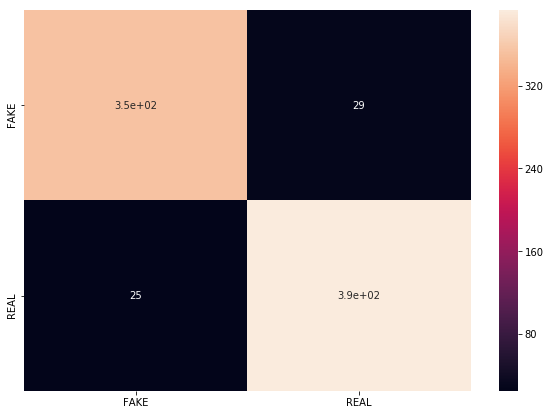

In [132]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[TP, FP], 
         [FN, TN]]
df_cm = pd.DataFrame(array,
                     index = [i for i in ["FAKE", "REAL"]],
                     columns = [i for i in ["FAKE", "REAL"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## 7. Conclusion